In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = '/content/drive/MyDrive/picture'
labels = '/content/drive/MyDrive/Color_label'


In [ ]:
import numpy as np
import pandas as pd
import six

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
from skimage.transform import resize


from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.layers import Dense, Dropout, Input

from keras import backend as K
import tensorflow as tf

from keras.applications import imagenet_utils
from keras.regularizers import l2


from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers import LayerNormalization
from keras.layers.pooling import MaxPooling2D

In [ ]:
#img_size_ori = 228
#img_size_target = 128

#def upsample(img):
    #if img_size_ori == img_size_target:
       # return img
    #return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
#def downsample(img):
    #if img_size_ori == img_size_target:
       # return img
   # return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [ ]:
import os
from glob import glob
import seaborn as sns
from PIL import Image

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

ims = [read(os.path.join(data, filename)) for filename in os.listdir(data)]
X_pic = np.array(ims, dtype='uint8')



In [ ]:
label = [read(os.path.join(labels, filename)) for filename in os.listdir(labels)]
y_pic = np.array(label, dtype='uint8')

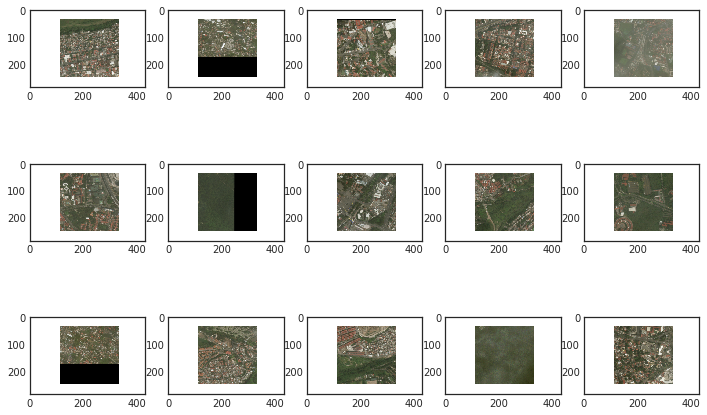

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(X_pic[i], interpolation='nearest')
plt.show()

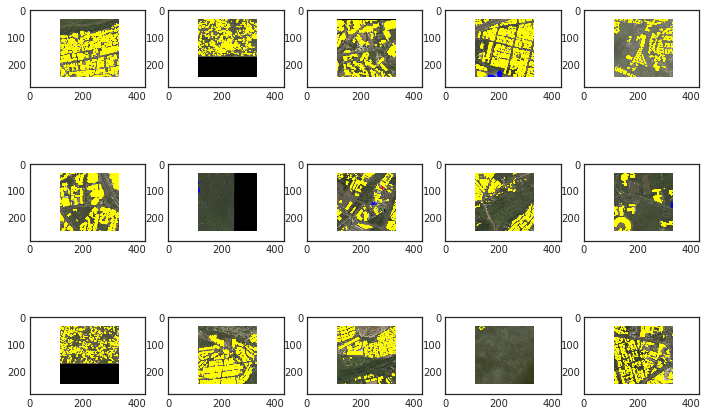

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(y_pic[i], interpolation='nearest')
plt.show()

In [ ]:
X_pic = X_pic/255.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_pic, y_pic, test_size=0.3)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(81, 288, 432, 3)
(81, 288, 432, 3)
(36, 288, 432, 3)
(36, 288, 432, 3)


In [ ]:
def create_model(input_shape, pool_size):
  x= input_tensor
  x=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same')(x)
  x=tf.keras.layers.BatchNormalization(x)
  x=tf.keras.layers.Activation('relu')(x)
  x=tf.keras.layers.MaxPool2D(pool_size)(x)









SyntaxError: ignored

U-NET MODEL

In [ ]:
def handle_block_names(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer


def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [ ]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
    for i in range(n_upsample_blocks):

        
        if i < len(skip_layers):
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)

    if classes < 2:
        activation = 'sigmoid'

    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

**RESNET-34**

In [ ]:
def _bn_relu(input):
    
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
  
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
  
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    """
    def f(input):

        if is_first_block_of_first_layer:
            
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, block_fn, repetitions,input_tensor):
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        
        if K.image_data_format() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        
        block_fn = _get_block(block_fn)
        
        if input_tensor is None:
            img_input = Input(shape=input_shape)
        else:
            if not K.is_keras_tensor(input_tensor):
                img_input = Input(tensor=input_tensor, shape=input_shape)
            else:
                img_input = input_tensor
                
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(img_input)
        pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),strides = (2,2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        
        block = _bn_relu(block)

        model = Model(inputs=img_input, outputs=block)
        return model

    @staticmethod
    def build_resnet_34(input_shape,input_tensor):
        return ResnetBuilder.build(input_shape, basic_block, [3, 4, 6, 3],input_tensor)

U-Net with ResNet34 Encoder

In [ ]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='upsampling',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

    backbone = ResnetBuilder.build_resnet_34(input_shape=input_shape,input_tensor=input_tensor)

    skip_connections = list([97,54,25])  
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'

    return model


In [ ]:
model = UResNet34(input_shape=(1,288,432))

ValueError: ignored